### Instalar pacotes

Este código precisa de algumas bibliotecas para rodar.<br>
Abaixo estão os comando para sua instalação:

In [1]:
# !pip install bitstring

### Código Auxiliar

In [48]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from itertools import product
from bitstring import BitArray, Bits, BitStream
from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

In [3]:
# Conferência de versão - a função kmeans.cluster_centers_ só funciona na versão 1.2.2 do sklearn
import sklearn
print(sklearn.__version__)


1.2.2


In [4]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))
        
        self._mat2bytes(mat_rgb_ids)
        
    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()
        
        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=int(rgb_id), length=self.num_bits_uint_))
        
    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_
        
        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)
        
        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]
                
        return im_rgb

In [5]:
def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

In [6]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

In [ ]:


img_original=load_sample_image('china.jpg')

#imagem original
plt.imshow(img_original)


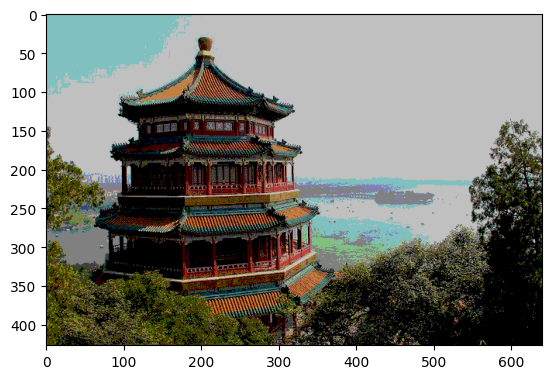

In [33]:
#imagem em 64 cores feita com o codigo original

# obtem as matrizes para gerar a imagem em rgb
mat_img, dict_img = uniform_quant(img_original, 64)

# gera a imagem em rgb
obj_1 = MyImgFormat(mat_img, dict_img)
img_1=img_code_1.unpack()
#print(mat_img)

plt.imshow(img_1)

In [34]:
import numpy as np
from itertools import product

def uniform_quant_meio(im, n_colors):
    # numero de valores em cada canal
    n_vals_ch = int(np.cbrt(n_colors))
    # tamanho do bin - limita a 128, metade do original
    bin_size = 128 // n_vals_ch
    
    # lista de possiveis valores pra cada canal e pixel 
    ch_vals = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    # quantizacao: divide valores dos pixeis pelo tamanho do bin size e resulta inteiro
    im_qt_rgb = im // bin_size
    # seta maximo valor das cores, limitado ao numero de cores no canal
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    # valores de pixeis quantizados
    im_qt_rgb = np.uint8((im_qt_rgb) * bin_size)
    
    # mapeando IDs
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    # matrizes de IDs e cores
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    

    return mat_ids, dict_id2pixel


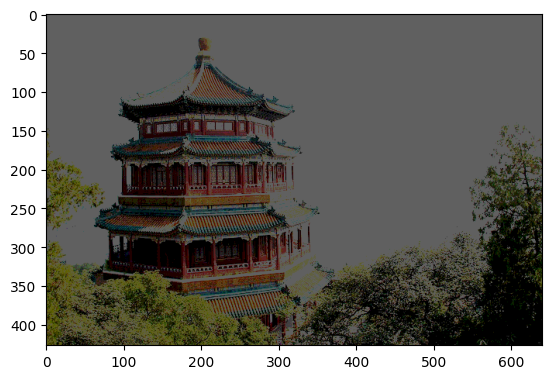

In [35]:


#Imagem em 64 cores feita com codigo modificado
mat_img_64, dict_img_64 = uniform_quant_meio(img_original, 64)
#print(mat_img)

obj_64 = MyImgFormat(mat_img_64, dict_img_64)

img_64 = obj_64.unpack()
plt.imshow(img_64)

In [40]:
# Comparar tamanho das 3 imagens

# Explicação: o código original mantém o tamanho dos bins, pois faz o cálculo 256//n_values
# e uma imagem RGB tem 256 cores. O novo código permite a metade do tamanho, assim a imagem quantizada 
# tem 2**2=4, 4 vezes menos o tamanho em kb, aproximadamente
print('original:',get_bin_size_kb(img),'\n64 cores codigo original:',get_bin_size_kb(obj_1),'\n64 cores com codigo novo:',get_bin_size_kb(obj_64))

original: 820.005 
64 cores codigo original: 206.207 
64 cores com codigo novo: 206.207


In [39]:
# ao desempacotar as imagens elas voltam a ser RGB no tamanho original

#imagem com o codigo original
myimg_1_rgb = obj_1.unpack()
#imagem com o codigo novo
myimg_rgb = obj_64.unpack()
print('original',get_bin_size_kb(img_original),'\n64 cores com codigo orginal',get_bin_size_kb(myimg_1_rgb),'\n64 cores com codigo novo',get_bin_size_kb(myimg_rgb))

original 820.005 
64 cores com codigo orginal 820.005 
64 cores com codigo novo 820.005


C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


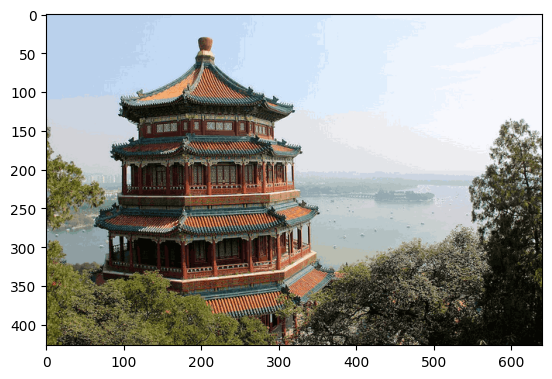

In [88]:
# Exercicio 2

# Quantização de imagens com K Means
# usando o K-Means para determinar os valores RGB de cada um dos IDs das cores

# Importando algoritmo kmeans
from sklearn.cluster import KMeans

# Carrega a imagem a ser usada
img = load_sample_image('china.jpg')

def kmeans_64(img,n_colours):
    # Kmeans com 64 cores (64 agrupamentos de valores de cor)
    kmeans = KMeans(
        # numero de cores desejado
        n_clusters=n_colours,
        # parametro para acelerar convergência do modelo, seleciona centroides iniciais baseado na probabilidade da contribuição dos pontos
        init='k-means++',
        max_iter=10,
        random_state=42
    )

    # Transforma a imagem numa matriz com tres colunas
    X = img.reshape((-1,3))

    # Calcula os clusters pelo kmeans e define os clusteres mais proximos a cada array em X
    clusters = kmeans.fit_predict(X)

    # Transforma os clusters numa imagem do tamanho original
    img_clusters = clusters.reshape((427,640))

    # Matriz vazia para preencher com pixeis
    img_kmeans = np.zeros(img.shape, dtype='uint8')

    # Preenchendo com os pixeis RGB
    for i in range(img.shape[0]): #percorre as linhas
        for j in range(img.shape[1]):  #percorre as colunas
            cluster_id = img_clusters[i, j] # pega o ID do elemento
            img_kmeans [i, j, :] = np.uint8(kmeans.cluster_centers_[cluster_id]) # preenche o pixel
    return np.array(img_kmeans)

img_kmeans= kmeans_64(img, 64)
plt.imshow(img_kmeans)
# Comentário dos resultados

# A imagem gerada pelo codigo original é mais brilhante que a gerada pelo meu, pois o menor tamanho da bin
# faz com que as cores sejam menos precisas. Com a perda de detalhes, a imagem fica mais escura
# No kmeans, é visível que o céu ficou com espaços de cores bem separados
# o que se dá porque o algoritmo faz primeiro a junção das cores parecidas em uma mesma cor (centroide)
# logo, elas ficam mais diferentes umas das outras, por isso parece ter mais separação
# enquanto na questão 1, as cores são aproximadas para o valor mais próximo do original





C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

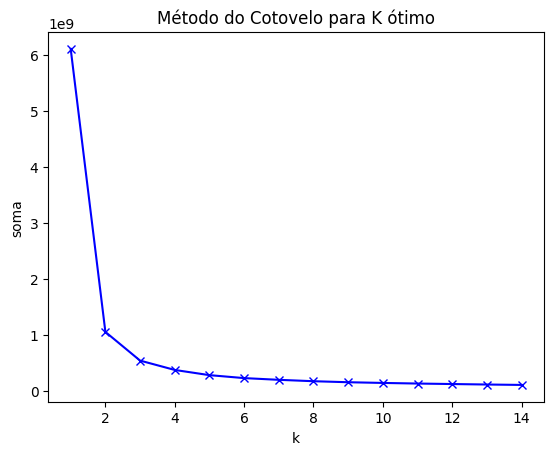

C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [89]:
# Questão 3 
# Quantidade ótima de clusteres para kmeans baseada na análise de medida de inércia
# Existem diversas maneiras de se estimar a quantidade "ótima" de clusters
# para um algoritmos como K-Means. Uma delas é uma análise baseada na
# medida de inércia, que é apresentada neste link. Implemente o cálculo da
# inércia dentro da função de quantização baseada no K-Means.
# b) Implemente uma função de comparação que calcula o MSE entre os pixels
# da imagem original e os da imagem quantizada.




# img contem os pixeis da imagem original
img = load_sample_image('china.jpg')



# Kmeans com inercia - calcula o numero ótimo de clusters pelo método do cotovelo e aplica o kmeans

# Conforme i cresce, a soma tende a zero, pois mais clusteres são criados
# O 'cotovelo' do gráfico em forma de braço é o k ótimo
def kmeans_inertia(img):
    

    # Transforma a imagem numa matriz com tres colunas
    X = img.reshape((-1,3))

    # Soma das distancias quadradas
    sum_sd=[]
    K = range(1,15)

    # Lista de somas para cada quantidade de clusters no range K
    for i in K:
        kmeans = KMeans(n_clusters=i)
        kmeans = kmeans.fit(X)
        sum_sd.append(kmeans.inertia_)

    # Gráfico no range dado
    plt.plot(K, sum_sd, 'bx-')
    plt.xlabel('k')
    plt.ylabel('soma')
    plt.title('Método do Cotovelo para K ótimo')
    plt.show()

    #  Ao analisar o gráfico, em i=3 tem o valor ótimo, possivelmente, porque há três cores primárias 
    # que compões todas as demais

    kmeans = KMeans(
        # numero de cores desejado
        n_clusters=3,
        # parametro para acelerar convergência do modelo, seleciona centroides iniciais baseado na probabilidade da contribuição dos pontos
        init='k-means++',
        max_iter=10,
        random_state=42
    )

    

    # Calcula os clusters pelo kmeans e define os clusteres mais proximos a cada array em X
    clusters = kmeans.fit_predict(X)

    # Transforma os clusters numa imagem do tamanho original
    img_clusters = clusters.reshape((427,640))

    # Matriz vazia para preencher com pixeis
    img_kmeans = np.zeros(img.shape, dtype='uint8')

    # Preenchendo com os pixeis RGB
    for i in range(img.shape[0]): #percorre as linhas
        for j in range(img.shape[1]):  #percorre as colunas
            cluster_id = img_clusters[i, j] # pega o ID do elemento
            img_kmeans [i, j, :] = np.uint8(kmeans.cluster_centers_[cluster_id]) # preenche o pixel
    return K,img_kmeans, sum_sd

K,img_kmeans,sum_sd=kmeans_inertia(img)




In [65]:
def comparacao(img,img_kmeans):
    #mean squared error importado do numpy
    # Calcula pela norma de Frobenius: mse = raiz quadrada(soma de i a j(valor absoluto i,j)^2)
    mse = np.linalg.norm(img-img_kmeans)
    #MSE = mean_squared_error(img, img_kmeans)
    return mse
mse = comparacao(img,img_kmeans)
print(mse)

148144.69339466735


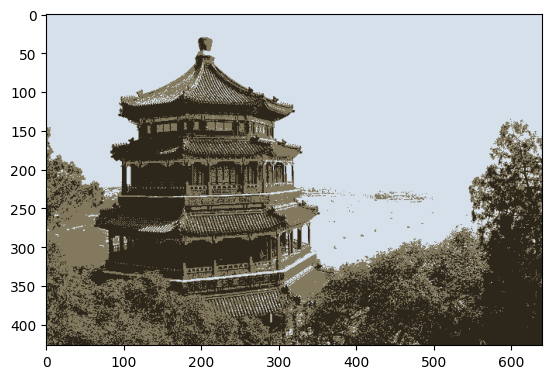

In [66]:
plt.imshow(img_kmeans)

In [69]:
# Questão 4
# Responda os itens a seguir usando as imagens 'china.jpg' e 'flower.jpg' do
# scikit-learn.
# a) Faça a quantização das imagens para {8, 27, 64, 125, 216} cores usando
# ambos os métodos de quantização (uniforme e K-Means)
# b) Compute e faça um plot da inércia dos resultados das quantizações do
# K-Means obtidas no item a)
# c) Compute e faça um plot dos MSEs de ambas as estratégias. Qual das
# estratégias teve um melhor MSE? Isso faz sentido quando fazemos uma
# comparação visual dos resultados?
# d) Compute e faça um plot do tamanho e KBs das imagens quantizadas e
# compare com o tamanho em KBs da imagem original. Faça a comparação
# considerando os seguintes pontos:
# ○ Use a função get_bin_size_kb para calcular os tamanhos das imagens
# em KBs;
# ○ Para a imagem original, calcule o tamanho do numpy.ndarray que
# contém os pixels RGB da imagem;
# ○ Para as imagens quantizadas, compute o tamanho do objeto
# MyImageFormat criado usando os resultados da quantização
img_china=load_sample_image('china.jpg')
img_flor = load_sample_image('flower.jpg')



# Questão c


# Questão d


In [133]:
# Questão a

# Método uniforme

# Primeira imagem
mat_c_8, dict_c_8 = uniform_quant_meio(img_china, 8)
mat_c_27, dict_c_27 = uniform_quant_meio(img_china, 27)
mat_c_64, dict_c_64 = uniform_quant_meio(img_china, 64)
mat_c_125, dict_c_125 = uniform_quant_meio(img_china, 125)
mat_c_216, dict_c_216 = uniform_quant_meio(img_china, 216)

q_uni_china_8 = MyImgFormat(mat_c_8, dict_c_8)
q_uni_china_27 = MyImgFormat(mat_c_27, dict_c_27)
q_uni_china_64 = MyImgFormat(mat_c_64, dict_c_64)
q_uni_china_125 = MyImgFormat(mat_c_125, dict_c_125)
q_uni_china_216 = MyImgFormat(mat_c_216, dict_c_216)

# Segunda imagem
mat_f_8, dict_f_8 = uniform_quant_meio(img_flor, 8)
mat_f_27, dict_f_27 = uniform_quant_meio(img_flor, 27)
mat_f_64, dict_f_64 = uniform_quant_meio(img_flor, 64)
mat_f_125, dict_f_125 = uniform_quant_meio(img_flor, 125)
mat_f_216, dict_f_216 = uniform_quant_meio(img_flor, 216)


q_uni_flor_8 = MyImgFormat(mat_f_8, dict_f_8)
q_uni_flor_27 = MyImgFormat(mat_f_27, dict_f_27)
q_uni_flor_64 = MyImgFormat(mat_f_64, dict_f_64)
q_uni_flor_125 = MyImgFormat(mat_f_125, dict_f_125)
q_uni_flor_216 = MyImgFormat(mat_f_216, dict_f_216)
# Método K means

# Primeira imagem
q_k_china_8 = kmeans_64(img_china, 8)
q_k_china_27 = kmeans_64(img_china, 27)
q_k_china_64 = kmeans_64(img_china, 64)
q_k_china_125 = kmeans_64(img_china, 125)
q_k_china_216 = kmeans_64(img_china, 216)

# Segunda imagem
q_k_flor_8 = kmeans_64(img_flor, 8)
q_k_flor_27 = kmeans_64(img_flor, 27)
q_k_flor_64 = kmeans_64(img_flor, 64)
q_k_flor_125 = kmeans_64(img_flor, 125)
q_k_flor_216 = kmeans_64(img_flor, 216)

C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

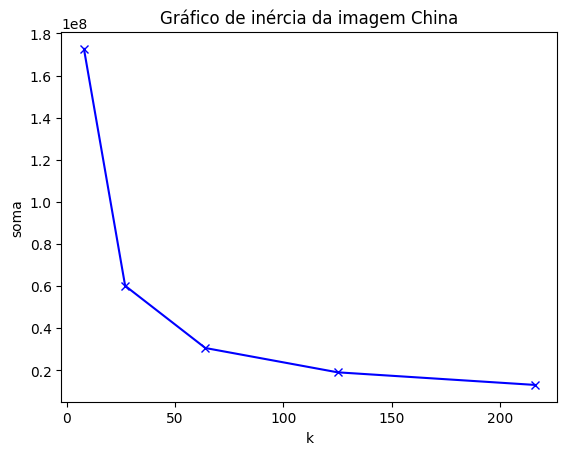

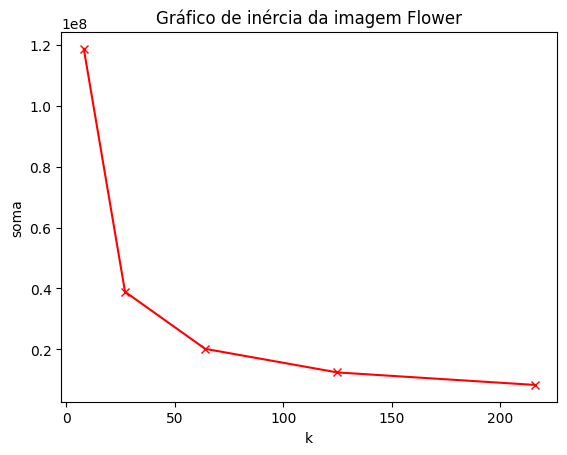

In [134]:
# Questão 4 b

# Transforma a imagem numa matriz com tres colunas
X = img_china.reshape((-1,3))
Y = img_flor.reshape((-1,3))
# Soma das distancias quadradas
X_sum_sd = []
Y_sum_sd = []
lista_sizes = [8,27,64,125,216]

# Lista de somas para cada quantidade de clusters no range K
for i in lista_sizes:
    kmeans = KMeans(n_clusters=i)
    kmeans = kmeans.fit(X)
    X_sum_sd.append(kmeans.inertia_)

for i in lista_sizes:
    kmeans = KMeans(n_clusters=i)
    kmeans = kmeans.fit(Y)
    Y_sum_sd.append(kmeans.inertia_)

# Gráfico no range dado imagem china
plt.plot(lista_sizes, X_sum_sd, 'bx-')
plt.xlabel('k')
plt.ylabel('soma')
plt.title('Gráfico de inércia da imagem China')
plt.show()

# Gráfico no range dado imagem china
plt.plot(lista_sizes, Y_sum_sd, 'rx-')
plt.xlabel('k')
plt.ylabel('soma')
plt.title('Gráfico de inércia da imagem Flower')
plt.show()


In [147]:
# MSEs # qual das duas estratégias teve o melhor?
# faz sentido fazendo comparação visual dos resultados/

# Listas de mses para plotar
mses_china_uniform = []
mses_flor_uniform = []

mses_china_kmeans = []
mses_flor_kmeans = []

# Listas de imagens
imgs_china_uniform = [q_uni_china_8, q_uni_china_27, q_uni_china_64, q_uni_china_125, q_uni_china_216]
imgs_flor_uniform = [q_uni_flor_8, q_uni_flor_27, q_uni_flor_64, q_uni_flor_125, q_uni_flor_216]


imgs_china_kmeans = [q_k_china_8, q_k_china_27, q_k_china_64, q_k_china_125, q_k_china_216]
imgs_flor_kmeans = [q_k_flor_8, q_k_flor_27, q_k_flor_64, q_k_flor_125, q_k_flor_216]


In [148]:

# Calculando os MSEs
for i in imgs_china_uniform:
    mse_cun = comparacao(img_china,i.unpack())
    mses_china_uniform.append(mse_cun)

for i in imgs_flor_uniform:
    mse_fun = comparacao(img_flor,i.unpack())
    mses_flor_uniform.append(mse_fun)

for i in imgs_china_kmeans:
    mse_ck = comparacao(img_china,i)
    mses_china_kmeans.append(mse_ck)

for i in imgs_flor_kmeans:
    mse_fk = comparacao(img_flor,i)
    mses_flor_kmeans.append(mse_fk)


In [ ]:
# Gráficos do MSE 
plt.plot(lista_sizes, mses_china_uniform,color='b')
plt.plot(lista_sizes, mses_flor_uniform, color='g')
plt.plot(lista_sizes, mses_china_kmeans, color='r')
plt.plot(lista_sizes, mses_flor_kmeans, color='y')
plt.xlabel('Quantidade de cores')
plt.ylabel('MSEs')
plt.title('Gráfico de MSEs')
plt.show()

## O gráfico mostra que a estratégia uniforme teve o melhor MSE
## Visualmente faz sentido porque as cores no kmeans ficam mais separadas, enquanto no método uniforme ficam mais uniformes
## Logo, no método uniforme as cores tem menos separação, e portanto a distância entre os valores de pixeis é menor, resultando em menor MSE

In [244]:
tamanhos_q_china_uniform =[]
tamanhos_q_flor_uniform =[]

tamanhos_q_china_kmeans =[]
tamanhos_q_flor_kmeans =[]

# Aplicando a função para obter tamanho em kb às imagens quantizadas
for i in imgs_china_uniform:
    tamanhos_q_china_uniform.append(get_bin_size_kb(i))

for i in imgs_flor_uniform:
    tamanhos_q_flor_uniform.append(get_bin_size_kb(i))

for i in imgs_china_kmeans:
    tamanhos_q_china_kmeans.append(get_bin_size_kb(i))

for i in imgs_flor_kmeans:
    tamanhos_q_flor_kmeans.append(get_bin_size_kb(i))

# nbytes retorna o tamanho em bytes, //1024 para ter em kb

tamanho_original_china = np.array(img_china).nbytes/1024
#array para comparacao no mesmo grafico
array_china = [tamanho_original_china, tamanho_original_china, tamanho_original_china, tamanho_original_china, tamanho_original_china]

tamanho_original_flor = np.array(img_flor).nbytes/1024
array_flor = [tamanho_original_flor ,tamanho_original_flor ,tamanho_original_flor ,tamanho_original_flor ,tamanho_original_flor ]

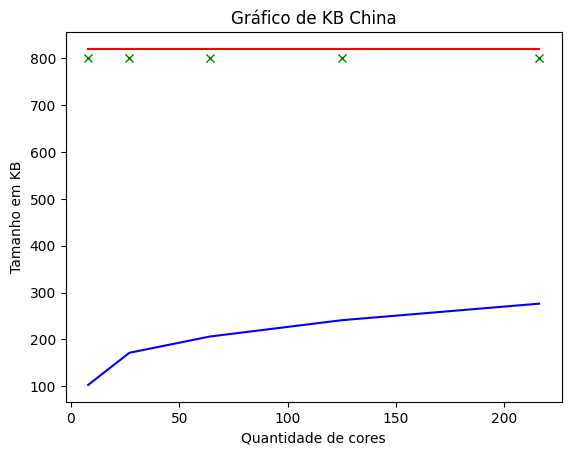

In [198]:
# Gráficos do KB 
plt.plot(lista_sizes, tamanhos_q_china_uniform,color='b')
plt.plot(lista_sizes, tamanhos_q_china_kmeans, color='r')
plt.plot(lista_sizes,array_china, 'gx')


plt.xlabel('Quantidade de cores')
plt.ylabel('Tamanho em KB')
plt.title('Gráfico de KB China')
plt.show()

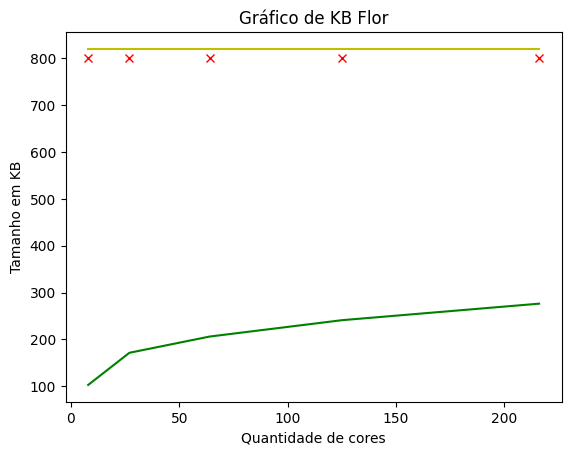

In [199]:
# Gráficos do KB 
plt.plot(lista_sizes, tamanhos_q_flor_uniform, color='g')
plt.plot(lista_sizes, tamanhos_q_flor_kmeans, color='y')
plt.plot(lista_sizes, array_flor,'rx')
plt.xlabel('Quantidade de cores')
plt.ylabel('Tamanho em KB')
plt.title('Gráfico de KB Flor')
plt.show()

In [ ]:
## Vê-se que o tamanho em kb da imagem original foi mantido na quantização pelo KMeans,
## enquanto o metodo uniforme ocupa mais espaço conforme mais cores são permitidas
## Deve haver um erro na obtenção do tamanho pelo kmeans, já que o objetivo da quantização é reduzir a 
## quantidade de cores e possivelmente espaço ocupado pelas imagens